In [0]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import time

In [0]:
neurons = 512                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mae'                  # loss function for calculating the gradient, in this case Mean Absolute Error
optimizer="adam"              # optimizer for appljying gradient decent
dropout = 0.25                 # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 64               
epochs = 50                   
window_len = 7                # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8           # porportion of data to be used for training
merge_date = '2016-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin
split_date = '2017-09-01'     # split point for the training and test set according to the training size, this is used for plotting

In [0]:
def get_market_data(market, tag=True):

  """

  market: the full name of the cryptocurrency as spelled on coinmarketcap.com. eg.: 'bitcoin'

  tag: eg.: 'btc', if provided it will add a tag to the name of every column.

  returns: panda DataFrame

  This function will use the coinmarketcap.com url for provided coin/token page. 

  Reads the OHLCV and Market Cap.

  Converts the date format to be readable. 

  Makes sure that the data is consistant by converting non_numeric values to a number very close to 0.

  And finally tags each columns if provided.

  """

  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 

                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]

  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  

  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))

  if tag:

    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]

  return market_data

In [0]:
def merge_data(a, b, from_date=merge_date):

  """

  a: first DataFrame

  b: second DataFrame

  from_date: includes the data from the provided date and drops the any data before that date.

  returns merged data as Pandas DataFrame

  """

  merged_data = pd.merge(a, b, on=['Date'])

  merged_data = merged_data[merged_data['Date'] >= from_date]

  return merged_data

In [0]:

def add_volatility(data, coins=['btc', 'eth']):

  """

  data: input data, pandas DataFrame

  coins: default is for 'btc and 'eth'. It could be changed as needed

  This function calculates the volatility and close_off_high of each given coin in 24 hours, 

  and adds the result as new columns to the DataFrame.

  Return: DataFrame with added columns

  """

  for coin in coins:

    # calculate the daily change

    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],

             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,

             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}

    data = data.assign(**kwargs)

  return data



In [0]:
def create_model_data(data):

  """

  data: pandas DataFrame

  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.

  Return: pandas DataFrame

  """

  data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]

  data = data.sort_values(by='Date')

  return data


In [0]:

def split_data(data, training_size=0.8):

  """

  data: Pandas Dataframe

  training_size: proportion of the data to be used for training

  This function splits the data into training_set and test_set based on the given training_size

  Return: train_set and test_set as pandas DataFrame

  """

  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


In [0]:
def create_inputs(data, coins=['btc', 'eth'], window_len=window_len):

  """

  data: pandas DataFrame, this could be either training_set or test_set

  coins: coin datas which will be used as the input. Default is 'btc', 'eth'

  window_len: is an intiger to be used as the look back window for creating a single input sample.

  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1

  Return: X, the input for our model as a python list which later needs to be converted to numpy array.

  """

  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]

  inputs = []

  for i in range(len(data) - window_len):

    temp_set = data[i:(i + window_len)].copy()

    inputs.append(temp_set)

    for col in norm_cols:

      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  

  return inputs




In [0]:

def create_outputs(data, coin, window_len=window_len):

  """

  data: pandas DataFrame, this could be either training_set or test_set

  coin: the target coin in which we need to create the output labels for

  window_len: is an intiger to be used as the look back window for creating a single input sample.

  This function will create the labels array for our training and validation and normalize it between 0 and 1

  Return: Normalized numpy array for 'Close' prices of the given coin

  """

  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1


In [0]:
def to_array(data):

  """

  data: DataFrame

  This function will convert list of inputs to a numpy array

  Return: numpy array

  """

  x = [np.array(data[i]) for i in range (len(data))]

  return np.array(x)

In [0]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):

  """

  inputs: input data as numpy array

  output_size: number of predictions per input sample

  neurons: number of neurons/ units in the LSTM layer

  active_func: Activation function to be used in LSTM layers and Dense layer

  dropout: dropout ration, default is 2.5

  loss: loss function for calculating the gradient

  optimizer: type of optimizer to backpropagate the gradient

  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 

  and finally a dense layer to produce the output using keras' sequential model.

  Return: Keras sequential model and model summary

  """

  model = Sequential()

  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))

  model.add(Dropout(dropout))

  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))

  model.add(Dropout(dropout))

  model.add(LSTM(neurons, activation=activ_func))

  model.add(Dropout(dropout))

  model.add(Dense(units=output_size))

  model.add(Activation(activ_func))

  model.compile(loss=loss, optimizer=optimizer)

  model.summary()

  return model

In [0]:
def show_plot(data, tag):

  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})

  ax1.set_ylabel('Closing Price ($)',fontsize=12)

  ax2.set_ylabel('Volume ($ bn)',fontsize=12)

  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])

  ax2.set_yticklabels(range(10))

  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])

  ax1.set_xticklabels('')

  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])

  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])

  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])

  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)

  fig.tight_layout()

  plt.show()

In [0]:
btc_data = get_market_data("bitcoin", tag='btc')
eth_data = get_market_data("ethereum", tag='eth')


In [0]:
btc_data.head()

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap
0,2018-03-01,10385.00,11052.30,10352.70,10951.00,7.317280e+09,175427000000
1,2018-02-28,10687.20,11089.80,10393.10,10397.90,6.936190e+09,180510000000
2,2018-02-27,10393.90,10878.50,10246.10,10725.60,6.966180e+09,175536000000
3,2018-02-26,9669.43,10475.00,9501.73,10366.70,7.287690e+09,163283000000
4,2018-02-25,9796.42,9923.22,9407.06,9664.73,5.706940e+09,165407000000


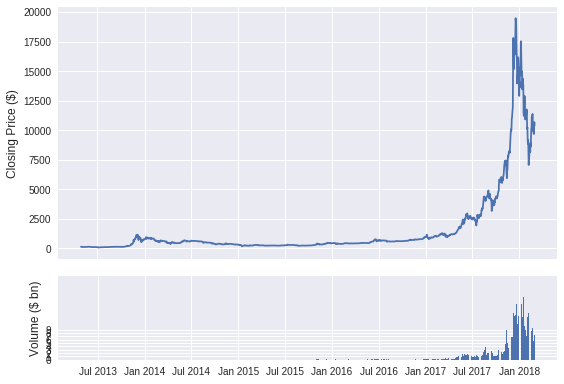

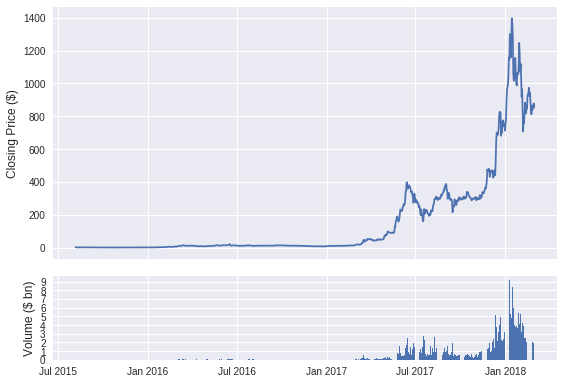

In [0]:
show_plot(btc_data, tag='btc')
show_plot(eth_data, tag='eth')

In [0]:
market_data = merge_data(btc_data, eth_data)
market_data = add_volatility(market_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)


In [0]:
model_data.tail()

,Date,btc_Close,btc_Volume,btc_close_off_high,btc_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
4,2018-02-25,9664.73,5.706940e+09,0.001589,0.052689,844.81,1646960000,-0.457914,0.036655
3,2018-02-26,10366.70,7.287690e+09,-0.777451,0.100654,869.32,2044480000,-0.418440,0.045038
2,2018-02-27,10725.60,6.966180e+09,-0.516445,0.060843,878.26,2053980000,0.234568,0.033503
1,2018-02-28,10397.90,6.936190e+09,0.986221,0.065190,855.20,1963980000,0.995427,0.039855
0,2018-03-01,10951.00,7.317280e+09,-0.710406,0.067366,872.20,1868520000,-0.429175,0.033154


In [0]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [0]:

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='btc')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='btc')

Y_train_eth = create_outputs(train_set, coin='eth')
Y_test_eth = create_outputs(test_set, coin='eth')


X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(625, 7, 8) (152, 7, 8) (625,) (152,)
(625, 7, 8) (152, 7, 8) (625,) (152,)


In [0]:
# clean up the memory
gc.collect()
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)
# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1067008   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
__________

625/625 [==============================] - 1s 1ms/step - loss: 0.0428 - val_loss: 0.0730
Epoch 7/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0379 - val_loss: 0.0717
Epoch 8/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0345 - val_loss: 0.0681
Epoch 9/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0369 - val_loss: 0.0677
Epoch 10/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0323 - val_loss: 0.0616
Epoch 11/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0315 - val_loss: 0.0591
Epoch 12/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0302 - val_loss: 0.0576
Epoch 13/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0314 - val_loss: 0.0592
Epoch 14/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0313 - val_loss: 0.0583
Epoch 15/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0291 - val_loss: 0.0592
Epoch

Epoch 19/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0271 - val_loss: 0.0562
Epoch 20/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0274 - val_loss: 0.0540
Epoch 21/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0276 - val_loss: 0.0544
Epoch 22/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0274 - val_loss: 0.0535
Epoch 23/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0275 - val_loss: 0.0522
Epoch 24/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0283 - val_loss: 0.0526
Epoch 25/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0275 - val_loss: 0.0583
Epoch 26/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0263 - val_loss: 0.0512
Epoch 27/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0268 - val_loss: 0.0528
Epoch 28/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0271 - val_los

625/625 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0529
Epoch 32/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0260 - val_loss: 0.0525
Epoch 33/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0515
Epoch 34/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0258 - val_loss: 0.0519
Epoch 35/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0504
Epoch 36/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0258 - val_loss: 0.0517
Epoch 37/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0256 - val_loss: 0.0539
Epoch 38/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0279 - val_loss: 0.0520
Epoch 39/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0264 - val_loss: 0.0532
Epoch 40/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0262 - val_loss: 0.0529
Ep

625/625 [==============================] - 1s 1ms/step - loss: 0.0256 - val_loss: 0.0515
Epoch 45/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0261 - val_loss: 0.0504
Epoch 46/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0268 - val_loss: 0.0533
Epoch 47/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0260 - val_loss: 0.0536
Epoch 48/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0254 - val_loss: 0.0510
Epoch 49/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0250 - val_loss: 0.0528
Epoch 50/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0268 - val_loss: 0.0497


In [0]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 512)            1067008   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
__________

625/625 [==============================] - 1s 1ms/step - loss: 0.0726 - val_loss: 0.0576
Epoch 7/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0741 - val_loss: 0.0553
Epoch 8/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0694 - val_loss: 0.0550
Epoch 9/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0733 - val_loss: 0.0621
Epoch 10/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0682 - val_loss: 0.0528
Epoch 11/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0648 - val_loss: 0.0546
Epoch 12/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0656 - val_loss: 0.0507
Epoch 13/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0503
Epoch 14/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0644 - val_loss: 0.0492
Epoch 15/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0632 - val_loss: 0.0494
Epoch

625/625 [==============================] - 1s 1ms/step - loss: 0.0633 - val_loss: 0.0482
Epoch 20/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0618 - val_loss: 0.0470
Epoch 21/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0584 - val_loss: 0.0476
Epoch 22/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0613 - val_loss: 0.0491
Epoch 23/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0605 - val_loss: 0.0508
Epoch 24/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0625 - val_loss: 0.0496
Epoch 25/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0603 - val_loss: 0.0517
Epoch 26/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0654 - val_loss: 0.0469
Epoch 27/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0615 - val_loss: 0.0506
Epoch 28/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0595 - val_loss: 0.0490
Ep

Epoch 32/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0587 - val_loss: 0.0476
Epoch 33/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0597 - val_loss: 0.0463
Epoch 34/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0593 - val_loss: 0.0469
Epoch 35/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0603 - val_loss: 0.0546
Epoch 36/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0599 - val_loss: 0.0481
Epoch 37/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0568 - val_loss: 0.0471
Epoch 38/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0574 - val_loss: 0.0499
Epoch 39/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0607 - val_loss: 0.0524
Epoch 40/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0593 - val_loss: 0.0496
Epoch 41/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0573 - val_los

625/625 [==============================] - 1s 1ms/step - loss: 0.0548 - val_loss: 0.0475
Epoch 46/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0551 - val_loss: 0.0480
Epoch 47/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0566 - val_loss: 0.0496
Epoch 48/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0587 - val_loss: 0.0504
Epoch 49/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0576 - val_loss: 0.0504
Epoch 50/50
625/625 [==============================] - 1s 1ms/step - loss: 0.0599 - val_loss: 0.0482


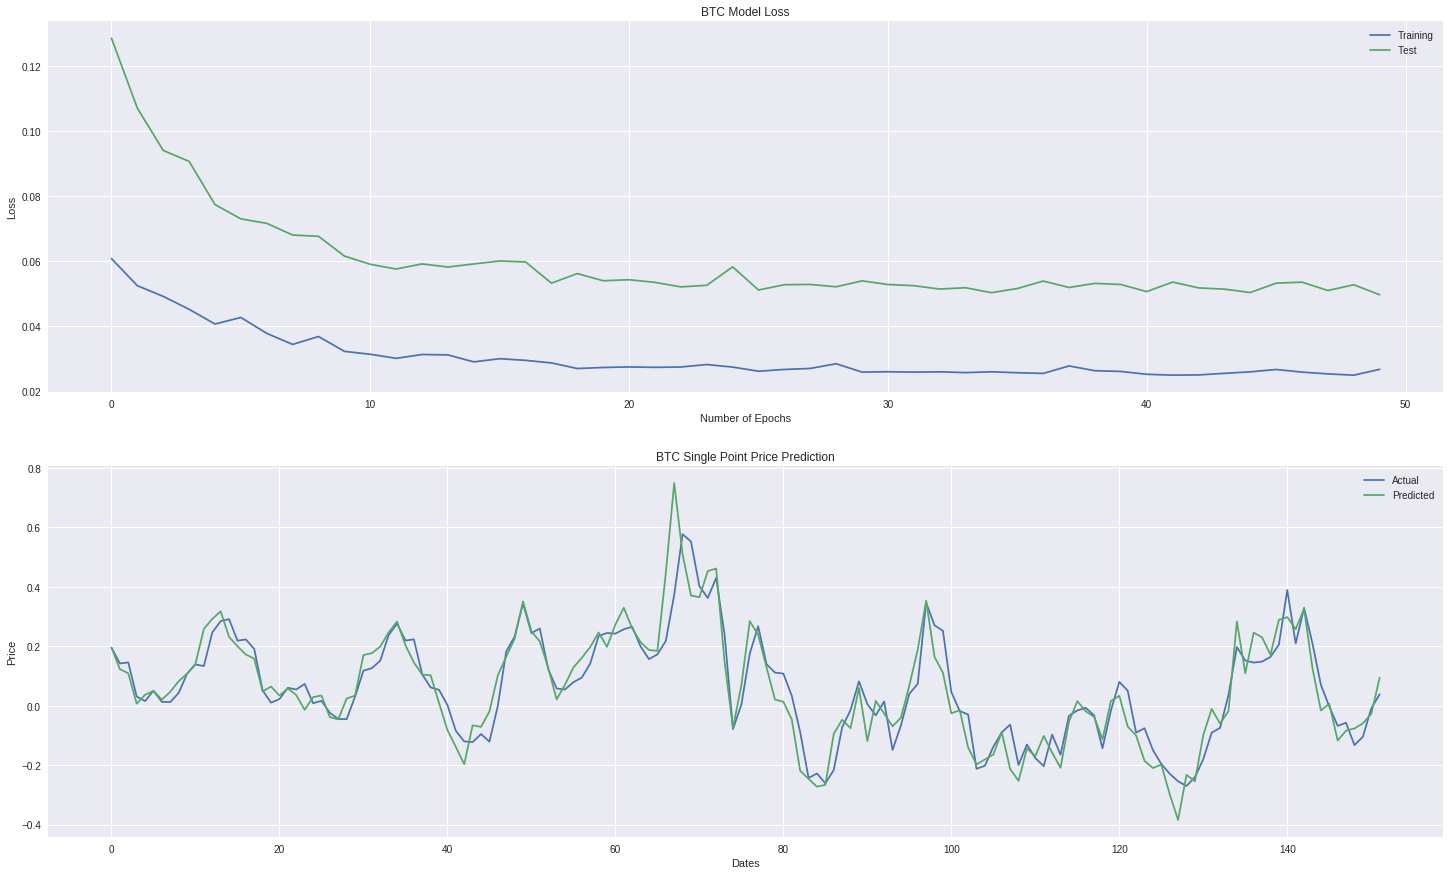

In [0]:
plt.figure(figsize=(25, 15))
plt.subplot(211)
plt.plot(btc_history.epoch, btc_history.history['loss'], )
plt.plot(btc_history.epoch, btc_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('BTC Model Loss')
plt.legend(['Training', 'Test'])

plt.subplot(212)
plt.plot(btc_model.predict(X_test))
plt.plot(Y_test_btc)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('BTC Single Point Price Prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()

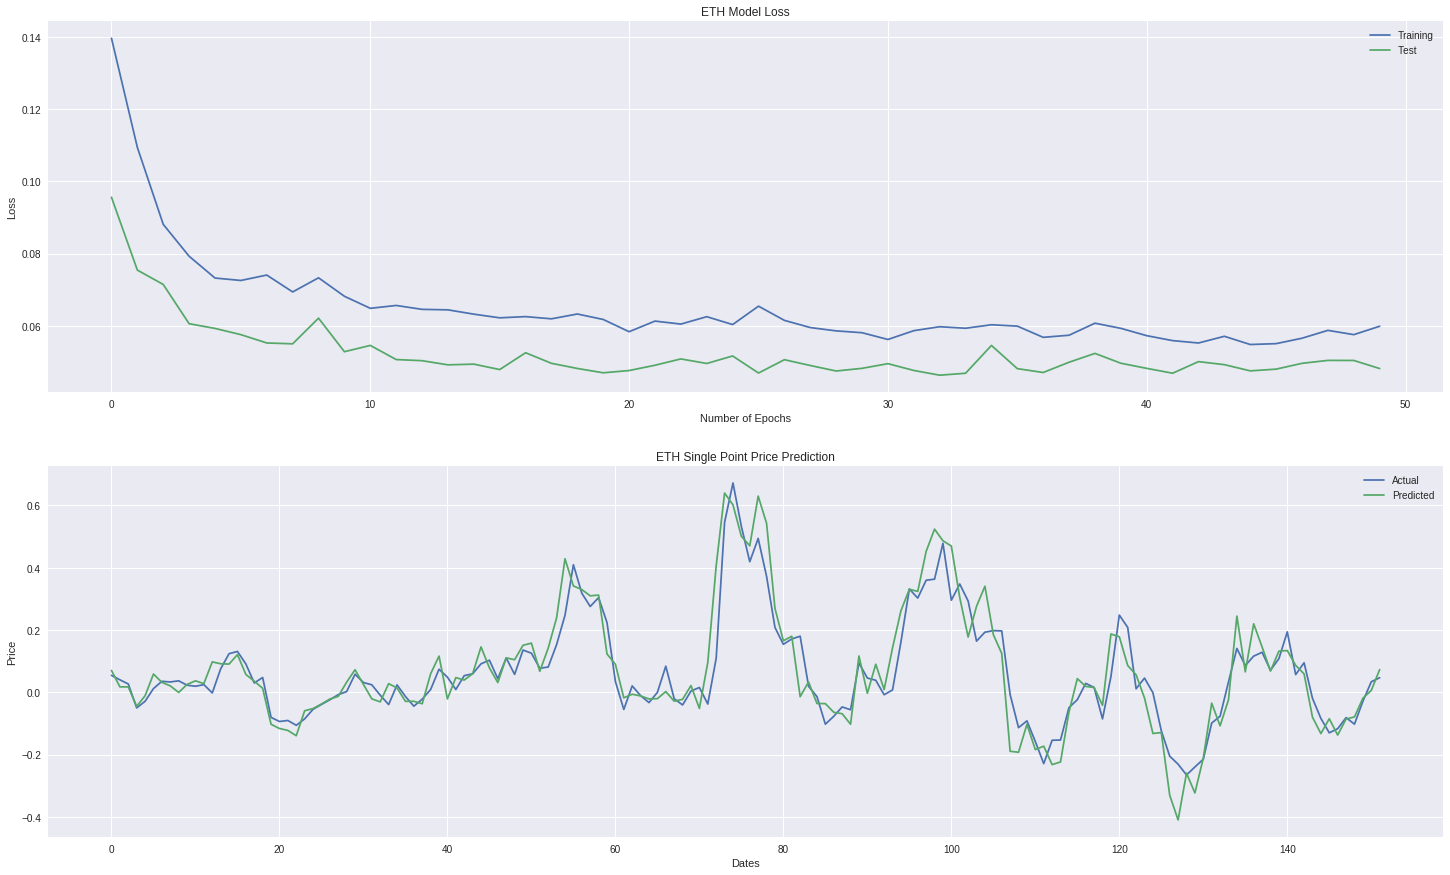

In [0]:

plt.figure(figsize=(25, 15)) 
plt.subplot(211)
plt.plot(eth_history.epoch, eth_history.history['loss'], )
plt.plot(eth_history.epoch, eth_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('ETH Model Loss')
plt.legend(['Training', 'Test'])
plt.subplot(212)
plt.plot(eth_model.predict(X_test))
plt.plot(Y_test_eth)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('ETH Single Point Price Prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()